# Scoring the Interest of a Response

**Goal**: Score responses by how interesting they may be.

**Properties of an Interesting Response (for our purposes)**:
- greater length
- variation of ideas (not paraphrasing the same sentences repeatedly)
- discussion of certain topics
  - race
  - gender
  - combat
  - training
- lack of discussion of certain topics
  - general comments about the survey itself
- clarity of response
  - few "unclear" tags

For sake of example, the responses to survey 64 will be used to develop an interest scoring method which, ideally, would be easily extendable to other surveys in the ASWWII corpus.

In [ ]:
import pandas as pd

In [ ]:
# Read in Survey 64 data
path = "../data/surveys_interest.xlsx"
df = pd.read_excel(path, na_filter=False, usecols=['T4'], dtype={'T4': str})

## Collecting Subscores

First, we consider the length of a response.

In [ ]:
df['length'] = df['T4'].apply(len)

### Response Sentence Similarity

Next, we'll use BERT to score the similarity of sentences in a response where a higher score would indicate a lot of redundancies in the response.

In [ ]:
import nltk
from itertools import combinations
import numpy as np
from scipy.spatial.distance import cosine

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')
;

In [ ]:
def similarity(res):
    
    # Split response into sentences
    # TODO: Find a better way to handle abbreviations
    res_split = nltk.sent_tokenize(res)
    
    # Too few sentences to do any comparison
    if len(res_split) < 2:
        return 0,0,0,0,0
    
    # Embed each sentence
    res_split_embed = model.encode(res_split)
    
    # Compare combinations of sentences
    sim = [1 - cosine(c[0], c[1]) for c in combinations(res_split_embed,2)]
    
    # Not sure whether the min, max, mean, or median
    #   would be the most useful, so return them all
    # Also return rank of response embedding matrix
    #   where each column is a different sentence
    return np.amax(sim), np.amin(sim), np.mean(sim), np.median(sim), np.linalg.matrix_rank(np.transpose(res_split_embed))

In [ ]:
# Apply function and unpack results
res = df['T4'].apply(similarity)
df['max'] = [r[0] for r in res]
df['min'] = [r[1] for r in res]
df['mean'] = [r[2] for r in res]
df['median'] = [r[3] for r in res]
df['rank'] = [r[4] for r in res]

### Response Topic

Finally, we will use BERT again to determine if a given response discusses certain topics. For a more detailed explanation of our BERT-contextualized keyword searching method, read through the "LongResponse_Filtering" notebook.

In [ ]:
import torch

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()
;

In [ ]:
def get_token_embeddings(text):
    
    # Tokenize the text
    split_text = text.split(". ")
    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)[:512] # Truncate if longer than 512
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Mark tokens belonging to a sentence
    segment_ids = [0]*len(tokenized_text)
    is_zero = True
    for i in range(len(tokenized_text)):
        segment_ids[i] = 0 if is_zero else 1
        if tokenized_text[i] == "[SEP]":
            is_zero = not is_zero

    # Convert to torch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    # Run through BERT
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Adjust
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    # Get token vectors
    token_vecs_sum = []
    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    return token_vecs_sum

In [ ]:
# Track the number of words in a given text that have
#   a high similarity to at least one keyword.
# Also track the highest similarity scores

# df: Dataframe
# column: column to consider for labeling
# label: name of column to store results in
# keys: keyword dictionary
# thresh: similarity threshold
def label_topic(df, column, label, keys, thresh):

    # Initialize/Reset column
    df[label] = 0
    df[label+"_score"] = float("-inf")
    
    # Track tokens that matched to keywords
    token_matches = []
    
    # Search
    for i in range(len(df)):
        best_sim = float("-inf")
        embed = get_token_embeddings(df[column][i])
        for j in range(len(embed)):
            for k in keys:
                sim = 1 - cosine(embed[j], k['embed'])
                if sim > best_sim:
                    best_sim = sim
                if sim >= thresh:
                    df.at[i, label] += 1
                    
                    # Get the token that matched to a keyword
                    split_text = df[column][i].split(". ")
                    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
                    tokenized_text = tokenizer.tokenize(marked_text)
                    token_matches.append((tokenized_text[j], k['text']))
                    
                    break
        
        df.at[i, label+"_score"] = best_sim
        
        # Track progress
        #if i%100==0:
        #    print(i,"/",len(df))
                    
    return token_matches

Some topics have been predetermined to be particularly interesting or uninteresting for the prosepective audience. First, we will consider the interesting topics.

In [ ]:
# Topic 1: Race
keys_race = [
    {"text": "negro soldier", "idx": 1, "embed": None},
    {"text": "the white man", "idx": 2, "embed": None}
]

for k in keys_race:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]
    
    
token_matches = label_topic(df, 'T4', 'topic_race', keys_race, 0.5)
print(set(token_matches))

In [ ]:
# Topic 2: Gender
keys_gender = [
    {"text": "woman", "idx": 1, "embed": None}
]

man_embed = get_token_embeddings("man")[1]
for k in keys_gender:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']] - (np.dot(embed[k['idx']], man_embed) / np.dot(man_embed, man_embed)) * man_embed
    
token_matches = label_topic(df, 'T4', 'topic_gender', keys_gender, 0.3)
print(set(token_matches))

In [ ]:
# TO DO: Expand the list of interesting topics

Now we will consider the uninteresting topics.

In [ ]:
# Topic 1: Survey
keys_survey = [
    {"text": "this is a good questionnaire", "idx": 5, "embed": None},
    {"text": "too many questions", "idx": 3, "embed": None},
    {"text": "questions about", "idx": 1, "embed": None},
]

for k in keys_survey:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]
    

token_matches = label_topic(df, 'T4', 'topic_survey', keys_survey, 0.52)
print(set(token_matches))

In [ ]:
# TO DO: Expand list of uninteresting topics
# e.g. "no comments"

### Response Clarity

In [ ]:
def clarity(res):
    if res.count("unclear") == 0:
        return 1
    return 1 - res.count("unclear") / len(res.split())

df['clarity'] = df['T4'].apply(clarity)

In [ ]:
# Save results to excel
df.to_excel("../data/surveys_interest.xlsx")

## Interest Function

In [8]:
# Reload data
import pandas as pd
path = "../data/surveys_interest.xlsx"
df = pd.read_excel(path, na_filter=False, dtype={'T4': str})
A = df.head(200).iloc[:,1:14].values # columns from length through clarity
b = df.head(200).iloc[:,14].values # predetermined interest

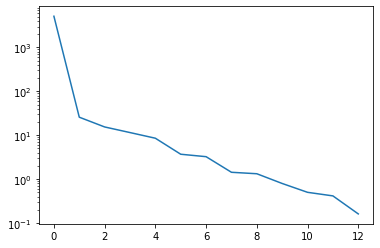

In [10]:
# Plot singular values of A
import matplotlib.pyplot as plt
import numpy as np
U,S,Vt = np.linalg.svd(A, full_matrices=False)
plt.semilogy(S)

### Version 1: Inverse Problem

In [12]:
# Solve: Ax = b
x = (Vt.T)*(1/S)@(U.T@b)

# May adjust the values in x as needed

def score(row):
    return np.dot(row[1:14], x)
    
df['interest_score_v1'] = df.apply(score, axis=1)

In [13]:
# Save results to excel
df.to_excel("../data/surveys_interest.xlsx", index=False)

In [ ]:
# Each entry in "row" can be modified to further fine tune results

# Appendix

## Using BERT to Embed Multi-Sentence Responses

To embed individual sentences, we used Sentence-BERT which is a tool extending BERT's base functionality to give "semantially meaningful sentence embeddings". The resulting embeddings from this method are comparable using cosine similarity [https://arxiv.org/abs/1908.10084]. 

In the following section, we demonstrate the use of Sentence-BERT to obtain comparable sentence embeddings.

### Sentence-BERT Demonstration

Ideally, we would expect similar sentences to have similar embeddings. For each pair of example sentences, we will measure the cosine similarity of their embeddings.

In [ ]:
# Example text
example_set_1 = [
    ['I like dogs.', 'I love dogs.'],
    ['I like dogs.', 'I want a puppy.'],
    ['I like dogs.', 'I like cats.'],
    ['I like dogs.', 'I want food.'],
    ['I like dogs.', 'The hound ran around the yard.'],
    ['I like dogs.', "It snowed today."]
]

In [ ]:
from prettytable import PrettyTable
from textwrap import fill

In [ ]:
def compare_text(example_set):
    
    # Initialize table
    t = PrettyTable(['Excerpt A', 'Excerpt B', 'Similarity'])
    
    for e in example_set:
        
        # Get embeddings for example
        embed = model.encode(e)
        
        # Calculate cosine similarity
        sim = 1 - cosine(embed[0], embed[1])
        
        # Add results to table
        t.add_row([fill(e[0], width=35), fill(e[1], width=35), round(sim,3)])
        
    # Display table
    print(t)

In [ ]:
compare_text(example_set_1)

### Embedding Multi-Sentence Responses

In the "LongResponse_Embedding" notebooks, different methods of embedding responses that may be multi-sentence were considered. For this purpose, we will revist Method 1 which simply passes the full response to the Sentence-BERT encoding function with no special handling.

This method is demonstrated below:

In [ ]:
example_set_2 = [
    [
        "The ground was covered in snow. Icicles hung from branches. Snowflakes kept falling.",
        "Winter has brought the coldest weather. This blizzard seems endless."
    ],
    [
        "Winter has brought the coldest weather. This blizzard seems endless.",
        "Rain waters the blooming flowers. Spring is finally here."
    ],
    [
        "Winter has brought the coldest weather. This blizzard seems endless.",
        "The table was filled with delicious food. I couldn't decide which dish to start with."
    ],
    [
        "The table was filled with delicious food. I couldn't decide which dish to start with.",
        "The smell coming from the stove is mouth-watering."
    ]
]

In [ ]:
compare_text(example_set_2)

From these results, we see that the embeddings of short multi-sentence pieces are still useful. For our purposes, the longest of survey responses are still just a few sentences, so we will assume most embeddings will not be too diluted for use.